<a href="https://colab.research.google.com/github/gauthiermartin/pytorch-deep-learning-course/blob/main/02_neural_network_classification_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classificiation with PyTorch

Classification is a problem of predicting wheter something is one thing or another (there can be multiple things as the option).

Resources :

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/


In [1]:
import torch
import sklearn

## 1. Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

# Make a 1000 samples

n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make a dataframe of circle data
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y})

In [6]:
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


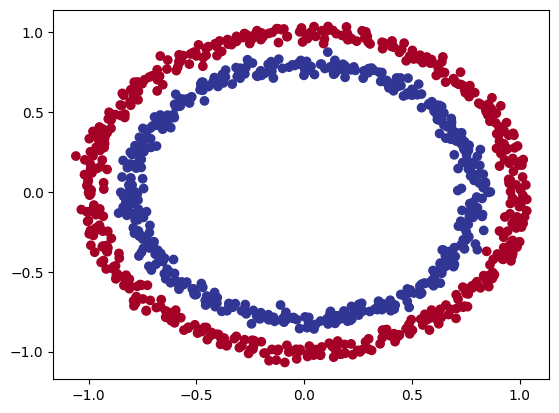

In [7]:
# Visualize, Visualize, Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** the data we're working with is often referred to as a toy dataset, a that is small enough to
experiment on but still sizable enough to practice the fundamentals.

 ### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
# View the first example features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for 1 sample of X : {X_sample}, and same for y: {y_sample}")
print(f"Shapes for on sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for 1 sample of X : [0.75424625 0.23148074], and same for y: 1
Shapes for on sample of X: (2,) and the same for y: ()


## 1.2 Turn our data into tensors and create train and test splits

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # 0.2 = 20% data test / 80% train

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
n_samples

1000

##2. Building a model

Let's build a model to classify our blue and red dots.

To do so we want to :

1. Setup device agnostic code so our code will run on a GPU if there is one
2. Construct a model(by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [15]:
import torch
from torch import nn

# Make our code device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

from torch.nn.parallel.data_parallel import data_parallel
No we've setup device agnostic code let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` that are capable of handeling the shape of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation)
4. Instanciate an instance of our model and send it to the target device

In [16]:
X_train.shape

torch.Size([800, 2])

In [17]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [18]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [19]:
# 1. Construct a model that subclass `nn.Module`
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create nn.Linear layers capables of handeling the shape of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 feature and upscale to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 feature from previous layer and outputing 1 (same shape as y)

  # 3. Define the forward() method
  def forward(self, x):
    return (self.layer_2(self.layer_1(x))) # x -> layer_1 -> layer_2 -> Output

# 4. Instanciate our model class and send it to the target device

model_0 = CircleModelV1().to(device)

In [20]:
device

'cuda'

In [21]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [22]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1939, -0.6775],
                      [-0.2090,  0.5240],
                      [ 0.5829,  0.1934],
                      [-0.2448, -0.5628],
                      [ 0.2496, -0.4124]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4699, -0.2058, -0.5212,  0.1076,  0.6326], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1862, -0.1770,  0.0050, -0.3364,  0.3332]], device='cuda:0')),
             ('1.bias', tensor([0.0230], device='cuda:0'))])

In [24]:
# Make some predicitons with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predicitons: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Lenght of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predicitions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predicitons: 200, Shape: torch.Size([200, 1])
Lenght of test samples: 200, Shape: torch.Size([200, 2])

First 10 predicitions:
tensor([[0.1421],
        [0.1621],
        [0.2522],
        [0.1102],
        [0.5106],
        [0.5208],
        [0.3726],
        [0.4572],
        [0.2412],
        [0.1663]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Set up loss function and optimizer

Which loss function or optimizer should we use ? (problem specific)

For example for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classificiation you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder the loss function mesure how **wrong** the model prediction are - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many more implemented


* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()` refer to resource listed here to have a better understanding
Resources:

Binary Cross Entropy (BSE) - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

What is a Logit in deep learning - https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow



In [25]:
# Setup the loss function
#loss_fun = nn.BCELoss() # BCELoss => Requires the inputs to have gone through the sigmoid activation function prior to input to BCELoss.
loss_fn = nn.BCEWithLogitsLoss() #BCELogitsLoss => Sigmoid activation function built in.


optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [26]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradiant descent)

### 3.1 Going from raw logits => predicition probabilities => predicition labels

Our model outputs are going to be raw **logits**.  

We can convert these **logits** into predicition probabilities by passing them to some kind of activations functions (e.g. sigmoid for binary classifiication and softmax for multiclass classificiation)

Then we can convert our model's predicition probabilities to **prediction label** by either rounding the or taking the `argmax()`

In [27]:
# View the first 5 output of the forward pass on the test data

model_0.eval()
with torch.inference_mode():
  y_logits = model_0(
      X_test.to(device)
  )[:5]
y_logits

tensor([[0.1421],
        [0.1621],
        [0.2522],
        [0.1102],
        [0.5106]], device='cuda:0')

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
# Use the signmoid activation function on our logits model to turn them into predicition probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5355],
        [0.5404],
        [0.5627],
        [0.5275],
        [0.6249]], device='cuda:0')

For our predicition probability values, we. need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5 `y=1` (class 1)
* `y_pred_probs` <= 0.5 `y=0` (class 0)

In [30]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of the extra dimenssion
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### 3.2 Training a training and testing loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evalutation steps

for epoch in range(epochs):
  ###Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits => pred probs => pred labels

  # 2. Calculate loss / accuracy

  loss = loss_fn(y_logits, ## nn.BCEWithLogitsLoss expect logits if you want to use y_pred use nn.BCELoss since it expect predicitons
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4.Loss backward (Backpropagation)
  loss.backward()

  # 5 Optimizer step (Gradiant descent)
  optimizer.step()

  ### Testing
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss / accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what happening
  if epoch %10 == 0 :
    print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.70937, Train Acc: 50.00% | Test Loss: 0.70459, Test Acc: 50.00%
Epoch: 10 | Train Loss: 0.69891, Train Acc: 57.25% | Test Loss: 0.69806, Test Acc: 57.50%
Epoch: 20 | Train Loss: 0.69572, Train Acc: 51.75% | Test Loss: 0.69653, Test Acc: 53.50%
Epoch: 30 | Train Loss: 0.69464, Train Acc: 51.38% | Test Loss: 0.69621, Test Acc: 50.50%
Epoch: 40 | Train Loss: 0.69420, Train Acc: 50.88% | Test Loss: 0.69615, Test Acc: 51.00%
Epoch: 50 | Train Loss: 0.69398, Train Acc: 50.38% | Test Loss: 0.69610, Test Acc: 49.00%
Epoch: 60 | Train Loss: 0.69383, Train Acc: 50.50% | Test Loss: 0.69604, Test Acc: 48.50%
Epoch: 70 | Train Loss: 0.69371, Train Acc: 50.50% | Test Loss: 0.69596, Test Acc: 48.00%
Epoch: 80 | Train Loss: 0.69361, Train Acc: 50.88% | Test Loss: 0.69588, Test Acc: 49.00%
Epoch: 90 | Train Loss: 0.69353, Train Acc: 50.75% | Test Loss: 0.69579, Test Acc: 49.00%
Epoch: 100 | Train Loss: 0.69346, Train Acc: 50.88% | Test Loss: 0.69571, Test Acc: 49.00%
Epoch: 110

## 4. Make predicitons and evalutate the model

From the metrics is looks like our model isn't learning anything ...

So to inspect it let's make some predicitons and make them visual

In other word, "Visualize, Visualize, Visualize"

To do so were going to import a function called `plot_decision_boundary` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [32]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not downloaded)

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download")
else:
  print("Dowloading helper_functions.py")
  response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(response.content)


Dowloading helper_functions.py


In [33]:
from helper_functions import plot_predictions, plot_decision_boundary

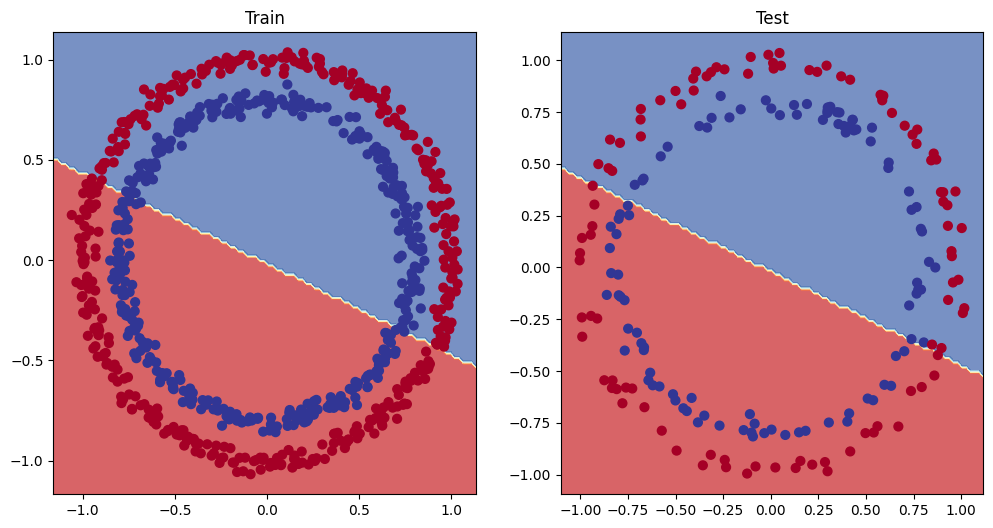

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Looks like our model is trying to seperate our circular data with a straight line. This does make senss since we only using linear layers

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more changes to learn about patterns in data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer - Increase the number of epoch
* Chainging the activation function
* Change the learning rate
* Change the loss function

These options are all from a model prespective because they deal directly with the model and not the data

And because these optionss are all values we can change they are refered as **hyperparameters**

Let's try and improve our model by :
* Adding more hidden units 5 => 10
* Increase the numbers of layers 2 => 3
* Increase the numbers of epochs 100 => 1000


In [35]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [37]:
# Write the training and evaluation loop for model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1.Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))


  # 2. Calculate the loss / accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(
      y_true=y_train,
      y_pred=y_pred
  )

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradiant descent)
  optimizer.step()

  ### Testing

  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate Loss
    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)


  ## Print out what's happenin

  if epoch % 100 == 0:
     print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69305, Train Acc: 50.38% | Test Loss: 0.69379, Test Acc: 48.00%
Epoch: 200 | Train Loss: 0.69299, Train Acc: 51.12% | Test Loss: 0.69437, Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.69298, Train Acc: 51.62% | Test Loss: 0.69458, Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.69298, Train Acc: 51.12% | Test Loss: 0.69465, Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69467, Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.69298, Train Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


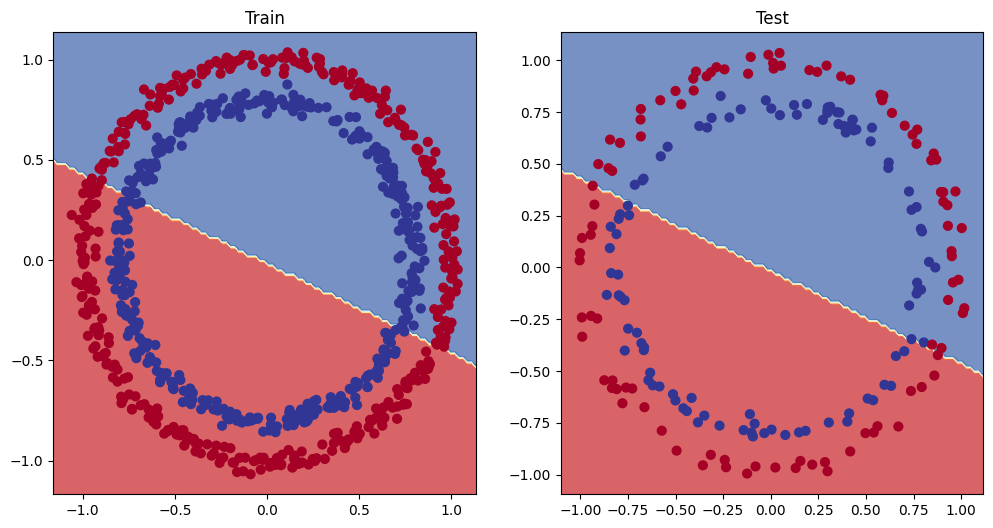

In [38]:
# Plot the decision boundry
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test a smaller problem


In [39]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [40]:
# Create train / test splits

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

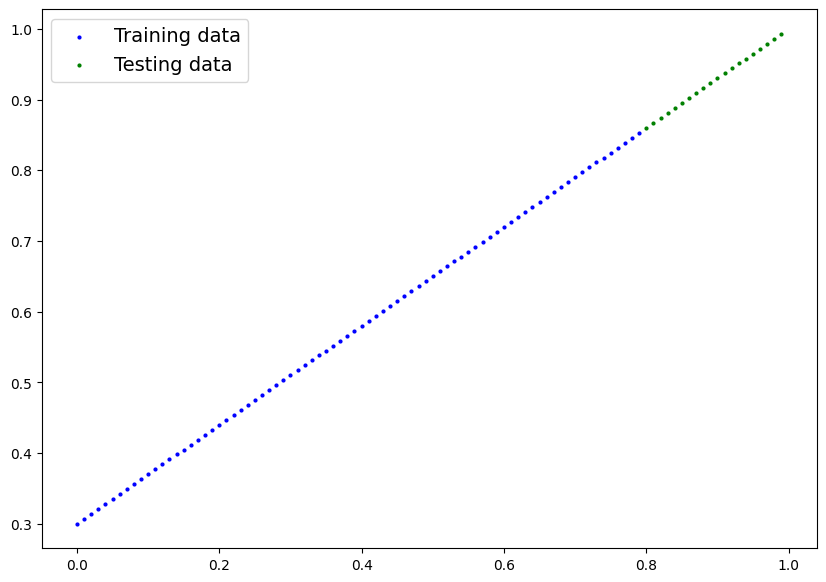

In [41]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

### 5.2 Adjusting `model_1` to fit a straight line

In [42]:
# Same architecture aas model_1 (but using nn.Sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Loss and optimizer
loss_fn = nn.L1Loss() #MAE Loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [44]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put the data on the targer device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


# Training

for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  #Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")






Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


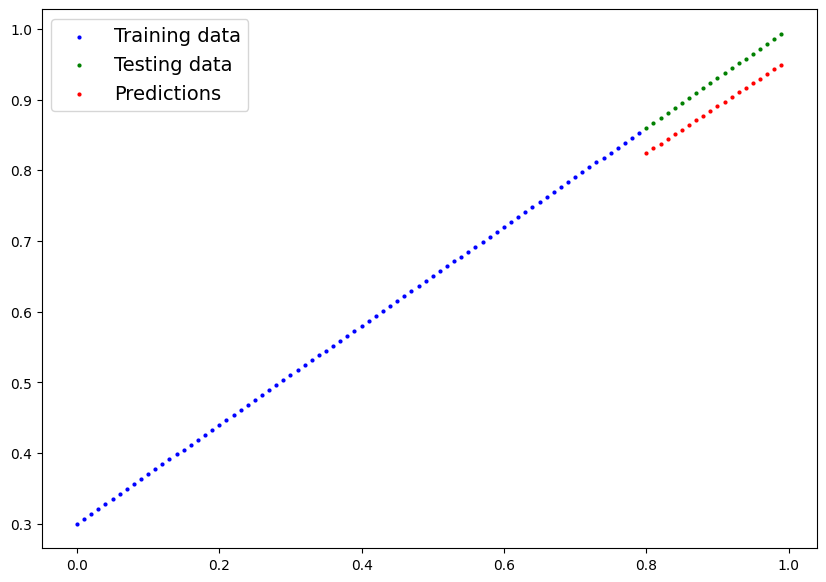

In [45]:
model_2.eval()

# Predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(
    train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu()
)

## 6. The missing piece: non-linearity

"What patterns could you draw if you where given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but in reality it is finite) linear and non-linear functions ?

### 6.1 Recreating non-linear data (red and blue circles)

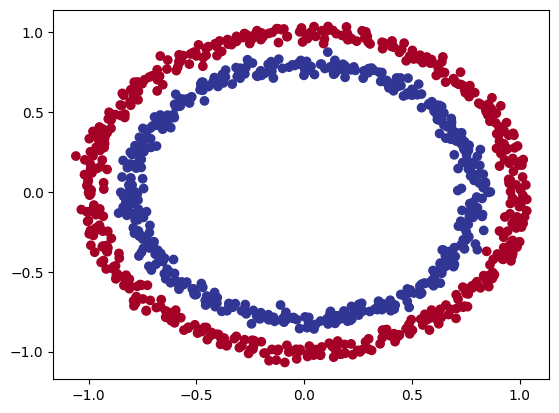

In [46]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


In [47]:
# Convert data to tensors than to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


#Split / train test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train[:5], y_train[:5], X_test[:5], y_test[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438]]),
 tensor([1., 0., 1., 0., 1.]))

from matplotlib import lines
### 6.2 Building a model with non-linearity

* Linear == Straight lines
* Non-Linear == Non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-linear functions (non-straight) which are potentially able to find patterns

In [48]:
# Build a model with non-linear activation functions

from torch import nn


class CircleModelV2(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() #relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation function ?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

# Binary classificiations problems

* Spam or not spam
* Claims: Fraud or not fraud

### 6.3 Training a model with non-linearity

In [49]:
# Setup loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model_3.parameters(),
    lr=0.1
)



In [50]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1600



for epoch in range(epochs):
  # Training
  model_3.train()

  # 1. Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))  # logits => predicition probabilities => prediction labels

  # 2. Calculate loss / accuracy
  loss = loss_fn(
      y_logits,
      y_train
  ) #BCEWithLogitsLoss => Takes logits as input
  acc = accuracy_fn(
      y_true=y_train,
      y_pred=y_pred
  )

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (Backpropagation)
  loss.backward()

  # 5. Optimizer step (Gradient descent)
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():

    # 1. Forward Pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss / accuracy
    test_loss = loss_fn(
        test_logits,
        y_test
    )
    test_acc = accuracy_fn(
        y_true=y_test,
        y_pred=test_pred
    )

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} , Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")





Epoch: 0 | Loss: 0.6929 , Accuracy: 50.00% | Test Loss: 0.6932 | Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.6912 , Accuracy: 52.88% | Test Loss: 0.6910 | Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.6898 , Accuracy: 53.37% | Test Loss: 0.6894 | Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.6879 , Accuracy: 53.00% | Test Loss: 0.6872 | Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.6852 , Accuracy: 52.75% | Test Loss: 0.6841 | Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.6810 , Accuracy: 52.75% | Test Loss: 0.6794 | Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.6751 , Accuracy: 54.50% | Test Loss: 0.6729 | Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.6666 , Accuracy: 58.38% | Test Loss: 0.6632 | Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.6516 , Accuracy: 64.00% | Test Loss: 0.6476 | Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.6236 , Accuracy: 74.00% | Test Loss: 0.6215 | Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.5682 , Accuracy: 87.75% | Test Loss: 0.5738 | Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

### 6.4 Evaluating a model trained with non-linear activation functions

In [51]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(X_test)).squeeze()

y_preds[:10], y_test[:10]

(tensor([[0., 1.],
         [1., 1.],
         [0., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 1.],
         [1., 1.],
         [0., 0.],
         [1., 1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

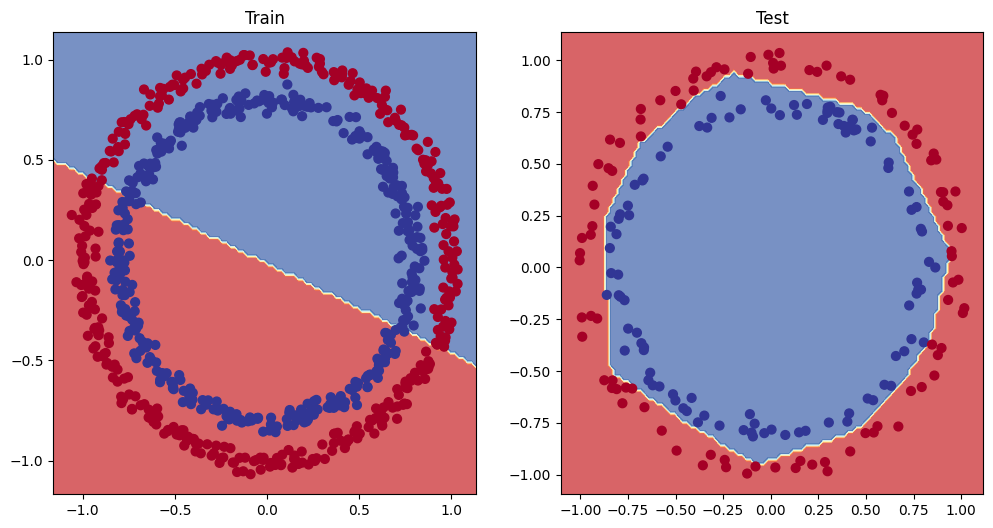

In [52]:
# Plot the decision boundries (Model 1 VS Model 3)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # Model 1 : No non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to learn patterns and data and it tries to figure out on it's own

And these tools are linear & non-linear functions

In [53]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

In [54]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

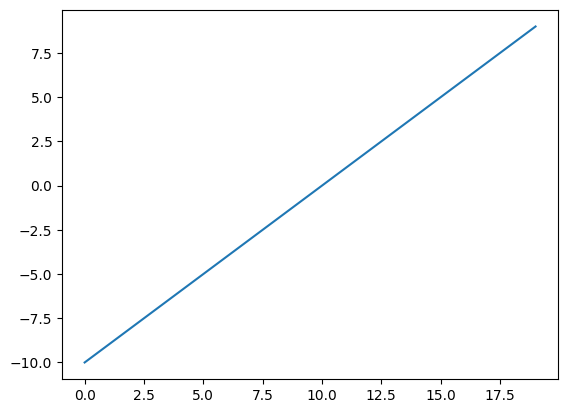

In [55]:
# Visualize the tensor
plt.plot(A)

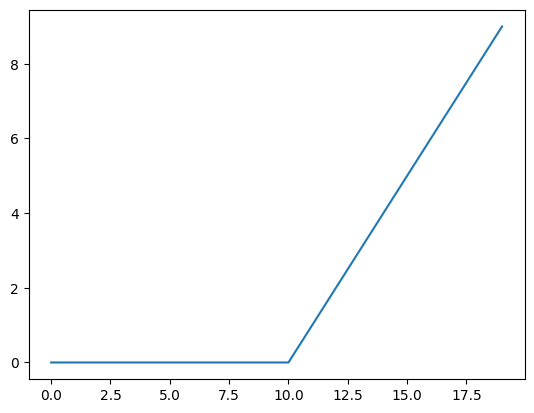

In [56]:
plt.plot(torch.relu(A))

In [58]:
def relu(x: torch.Tensor) -> torch.Tensor:
  retturn torch.maximum(torch.tensor(0), x) # input must be tensors

In [59]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [ ]:
# Plot ReLU activation function

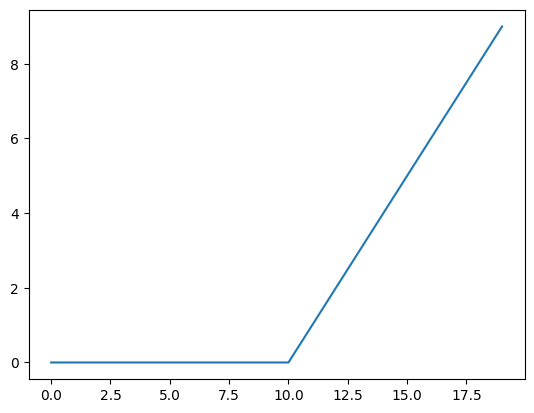

In [60]:
plt.plot(relu(A))

In [61]:
# Now let's do the same for sigmoid - https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1+torch.exp(-x))

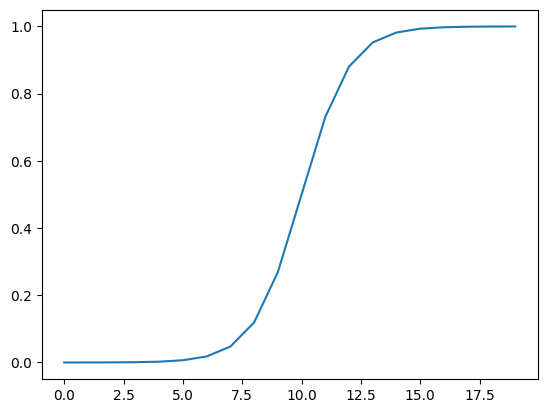

In [62]:
plt.plot(torch.sigmoid(A))

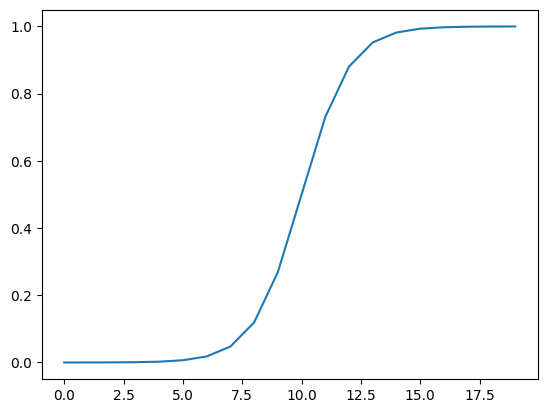

In [63]:
plt.plot(sigmoid(A))

### 8.Putting it all together with a multi-class classification problem

* Binary classification => one thing or the other (e.g. spam or not spam, dog or cat)
* Multi-class classification => more than one thing or another (cat vs dog vs monkey)

### 8.1 Creating a toy multiclass dataset

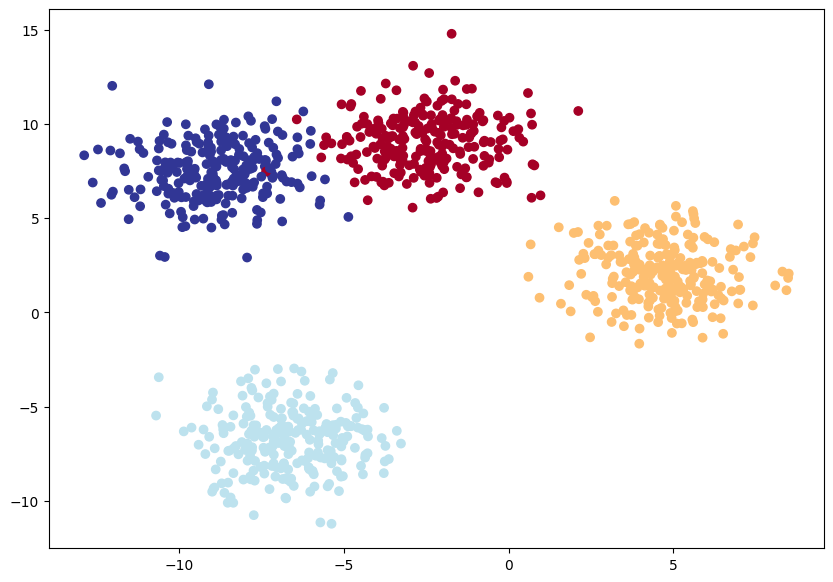

In [73]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set up the hyperparameters for data creation
NUM_CLASSES = 4
NUM_SAMPLES = 1000
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data

X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # Give the cluster a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)


# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data (Visualize, Visualize, Visualize)
plt.figure(figsize=(10,7))
plt.scatter(
    X_blob[:, 0],
    X_blob[:, 1],
    c=y_blob,
    cmap=plt.cm.RdYlBu
  )

### 8.2 Building a multi-class classificiation model in PyTorch

In [75]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [89]:
# Build a multi-class classificiation model
class BlobModel(nn.Module):
  def __init__(self, input_features:int, output_features:int, hidden_units:int=8):
    """
    Initilizes multi-class classificiation model

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output class)
      hidden_units(int): Number of hidden units between layers, default 8

    Returns :

    Example :
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
        nn.ReLU(),
    )

  def forward(self, x: torch.Tensor):
    return self.linear_layer_stack(x)


In [80]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [81]:
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

In [91]:
from os import device_encoding
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
  )
)

In [90]:
### 8.3 Create a loss function and optimizer for an multi-class classificiation model

loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classifications

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [87]:
### 8.4 Getting predicition probabilities for a multi-class PyTorch model


In [93]:
X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

In [95]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_train)
y_logits

tensor([[0.6226, 0.0000, 0.3042, 0.0000],
        [0.6736, 0.0000, 0.1842, 0.0000],
        [0.2130, 0.0000, 0.3891, 0.0000],
        ...,
        [0.7728, 0.0000, 0.2502, 0.0000],
        [0.2635, 0.0000, 0.3887, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')